## **Import libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Activation, Input, Flatten, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## **Download the dataset**

Download and extract the dataset from the below link in a folder.

https://drive.google.com/file/d/1SCpVEdJ6_YOAcy2iW05ENlMh-OCcFz3P/view?usp=sharing

In [2]:
!cd /content/
# !pip install gdown
! gdown --id 1SCpVEdJ6_YOAcy2iW05ENlMh-OCcFz3P # download dataset.zip
!unzip dataset.zip -d ./dataset # unzip dataset.zip
!pwd

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SCpVEdJ6_YOAcy2iW05ENlMh-OCcFz3P
To: /content/dataset.zip
100% 65.7M/65.7M [00:01<00:00, 51.6MB/s]
Archive:  dataset.zip
   creating: ./dataset/no/
  inflating: ./dataset/no/no0.jpg    
  inflating: ./dataset/no/no1.jpg    
  inflating: ./dataset/no/no10.jpg   
  inflating: ./dataset/no/no100.jpg  
  inflating: ./dataset/no/no1000.jpg  
  inflating: ./dataset/no/no1001.jpg  
  inflating: ./dataset/no/no1002.jpg  
  inflating: ./dataset/no/no1003.jpg  
  inflating: ./dataset/no/no1004.jpg  
  inflating: ./dataset/no/no1005.jpg  
  inflating: ./dataset/no/no1006.jpg  
  inflating: ./dataset/no/no1007.jpg  
  inflating: ./dataset/no/no1008.jpg  
  inflating: ./dataset/no/no1009.jpg  
  inflating: ./dataset/no/no101.jpg  
  i

In [87]:
!rm dataset.zip # remove dataset.zip

## **Read image files from directory**

To be familiar with keras dataset loading and preprocessing you can use the below link:

https://keras.io/api/preprocessing/image/

Please set ***validation_split = 0.2***

In [3]:
new_width = 128
new_height = 128
reshaped_image_size = (new_width, new_height)
batch_size = 32
# Load the dataset

# training_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(
training_ds, validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/",
    labels="inferred",
    label_mode="binary",
    color_mode="grayscale",
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=reshaped_image_size, # original 630*630 # Size to resize images to after they are read from disk, specified as (height, width). Defaults to (256, 256)
    shuffle=True,
    batch_size=batch_size,
)
num_of_classes = len(training_ds.class_names)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Using 600 files for validation.


In [4]:
class_names = training_ds.class_names
print(class_names)

['no', 'yes']


## **Display the dataset**

Plot some samples from the dataset to see and know what are you working with.

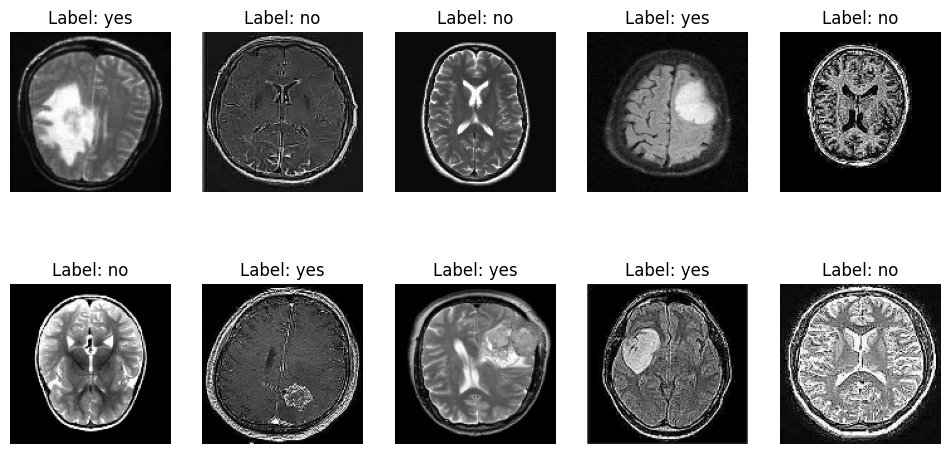

In [5]:
# note that label 0 is no tumor, label 1 is yes tumor
class_names = training_ds.class_names

# Plot some samples from the dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for images, labels in training_ds.take(1):
    for i, (image, label) in enumerate(zip(images[:10], labels[:10])):
        ax = axes[i // 5, i % 5]
        ax.imshow(image.numpy().astype("uint8"), cmap="gray") # image.shape = (32, 32, 3)
        # ax.set_title(f"Label: {label.numpy()}")
        ax.set_title(f"Label: {class_names[int(label.numpy())]}")
        ax.axis("off")
plt.show()


## **Build the models**

In this section you will build the model with two approaches.
First you should build it with the Sequential API and then you have to work with the Functional API in the second part.

You can use the below link to know more about these two APIs.

Keep the architecture as simple as possible.

https://medium.com/analytics-vidhya/keras-model-sequential-api-vs-functional-api-fc1439a6fb10

## **1.Sequential API**

### **Build a model**

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 128)       2

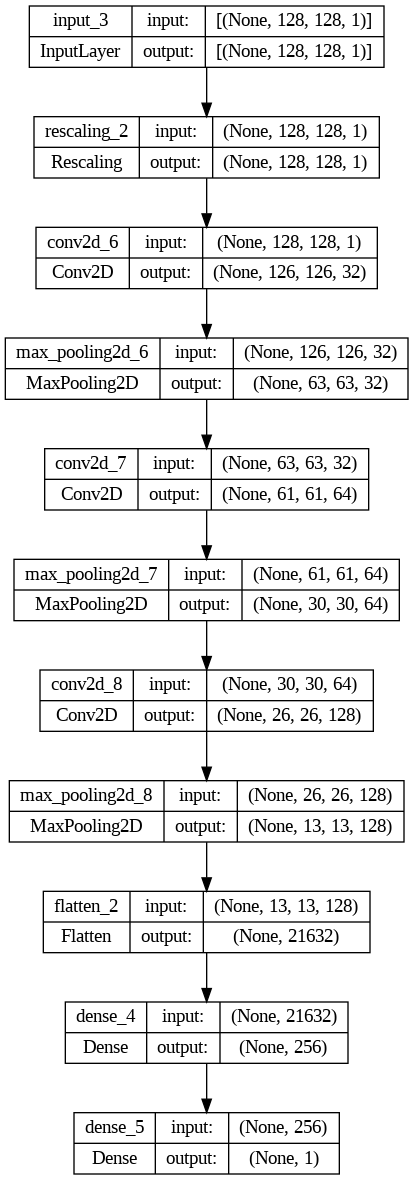

In [13]:
seq_model = Sequential([
    # Rescaling(1./255, input_shape=(new_width, new_height, 1)),
    Input(shape=(new_width, new_height, 1)),
    Rescaling(1./255),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(5, 5), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
], name="Sequential")

seq_model.summary()

tf.keras.utils.plot_model(seq_model, show_shapes=True)

### **Train the model**

In [14]:
seq_model.compile(
    optimizer=Adam(learning_rate=0.001),
    # loss='categorical_crossentropy', # use sparse_categorical_crossentropy when you have more than 2 classes
    loss='binary_crossentropy', # use binary_crossentropy when you have only 2 classes
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

seq_history = seq_model.fit(
    training_ds,
    epochs=30,
    callbacks=[early_stopping],
    validation_data=validation_ds,
)

Epoch 1/30
75/75 [==============================] - 5s 34ms/step - loss: 0.5174 - accuracy: 0.7563 - val_loss: 0.3423 - val_accuracy: 0.8500
Epoch 2/30
75/75 [==============================] - 2s 31ms/step - loss: 0.2878 - accuracy: 0.8825 - val_loss: 0.1888 - val_accuracy: 0.9267
Epoch 3/30
75/75 [==============================] - 6s 73ms/step - loss: 0.1660 - accuracy: 0.9342 - val_loss: 0.1669 - val_accuracy: 0.9400
Epoch 4/30
75/75 [==============================] - 2s 31ms/step - loss: 0.0924 - accuracy: 0.9696 - val_loss: 0.1267 - val_accuracy: 0.9583
Epoch 5/30
75/75 [==============================] - 3s 33ms/step - loss: 0.0507 - accuracy: 0.9858 - val_loss: 0.0908 - val_accuracy: 0.9733
Epoch 6/30
75/75 [==============================] - 4s 54ms/step - loss: 0.0183 - accuracy: 0.9954 - val_loss: 0.0838 - val_accuracy: 0.9800
Epoch 7/30
75/75 [==============================] - 2s 30ms/step - loss: 0.0087 - accuracy: 0.9983 - val_loss: 0.0923 - val_accuracy: 0.9800
Epoch 8/30
75

### **Test the model**

In [15]:
# Scores of sequential trained model.
scores = seq_model.evaluate(validation_ds)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

19/19 [==============================] - 1s 40ms/step - loss: 0.0838 - accuracy: 0.9800
Test loss: 0.08375508338212967
Test accuracy: 0.9800000190734863


### **Plot loss and accuracy**

In this part you should plot the loss and accuracy of train and test.

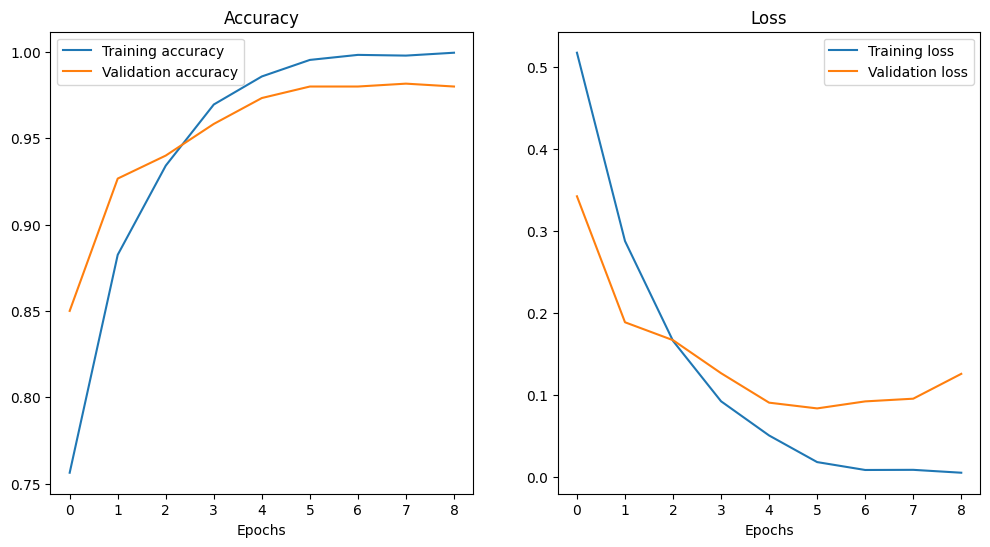

In [16]:

# Plot the training and validation accuracy and loss at each epoch
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(seq_history.history["accuracy"], label="Training accuracy")
axes[0].plot(seq_history.history["val_accuracy"], label="Validation accuracy")
axes[0].set_xlabel("Epochs")
axes[0].legend()
axes[0].set_title("Accuracy")

axes[1].plot(seq_history.history["loss"], label="Training loss")
axes[1].plot(seq_history.history["val_loss"], label="Validation loss")
axes[1].set_xlabel("Epochs")
axes[1].legend()
axes[1].set_title("Loss")

plt.show()


## **2.Functional API**

### **Build a model**

Model: "Functional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                  

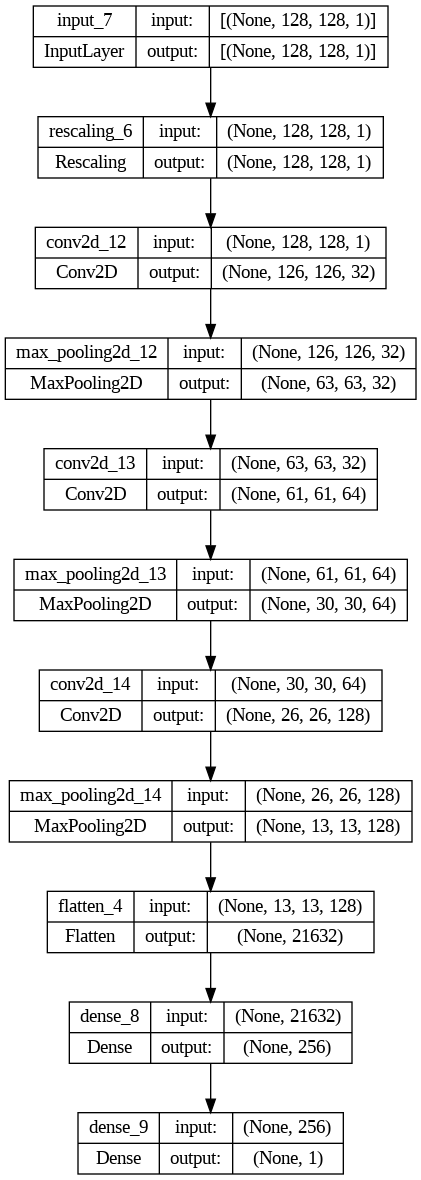

In [20]:
input_layer = Input(shape=(new_width, new_height, 1))
rescaled_input_layer = Rescaling(1./255)(input_layer)
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(rescaled_input_layer)
maxpool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(5, 5), activation='relu')(maxpool2)
maxpool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flatten_layer = Flatten()(maxpool3)
dense1 = Dense(256, activation='relu')(flatten_layer)
output_layer = Dense(1, activation='sigmoid')(dense1)

func_model = Model(inputs=input_layer, outputs=output_layer, name="Functional")

func_model.summary()

tf.keras.utils.plot_model(func_model, show_shapes=True)

### **Train the model**

In [21]:
func_model.compile(
    optimizer=Adam(learning_rate=0.001),
    # loss='categorical_crossentropy', # use sparse_categorical_crossentropy when you have more than 2 classes
    loss='binary_crossentropy', # use binary_crossentropy when you have only 2 classes
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

func_history = func_model.fit(
    training_ds,
    epochs=30,
    callbacks=[early_stopping],
    validation_data=validation_ds,
)

Epoch 1/30
75/75 [==============================] - 4s 32ms/step - loss: 0.5016 - accuracy: 0.7517 - val_loss: 0.3211 - val_accuracy: 0.8683
Epoch 2/30
75/75 [==============================] - 2s 30ms/step - loss: 0.2839 - accuracy: 0.8700 - val_loss: 0.2961 - val_accuracy: 0.8550
Epoch 3/30
75/75 [==============================] - 4s 47ms/step - loss: 0.1848 - accuracy: 0.9246 - val_loss: 0.1808 - val_accuracy: 0.9367
Epoch 4/30
75/75 [==============================] - 3s 34ms/step - loss: 0.0876 - accuracy: 0.9733 - val_loss: 0.0871 - val_accuracy: 0.9733
Epoch 5/30
75/75 [==============================] - 2s 30ms/step - loss: 0.0474 - accuracy: 0.9900 - val_loss: 0.1330 - val_accuracy: 0.9567
Epoch 6/30
75/75 [==============================] - 2s 29ms/step - loss: 0.0393 - accuracy: 0.9904 - val_loss: 0.1037 - val_accuracy: 0.9667
Epoch 7/30
75/75 [==============================] - 4s 48ms/step - loss: 0.0169 - accuracy: 0.9971 - val_loss: 0.1585 - val_accuracy: 0.9633
Epoch 7: earl

### **Test the model**

In [22]:
# Scores of functional trained model.
scores = func_model.evaluate(validation_ds)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

19/19 [==============================] - 1s 34ms/step - loss: 0.0871 - accuracy: 0.9733
Test loss: 0.08713722974061966
Test accuracy: 0.9733333587646484


### **Plot loss and accuracy**

In this part you should plot the loss and accuracy of train and test.

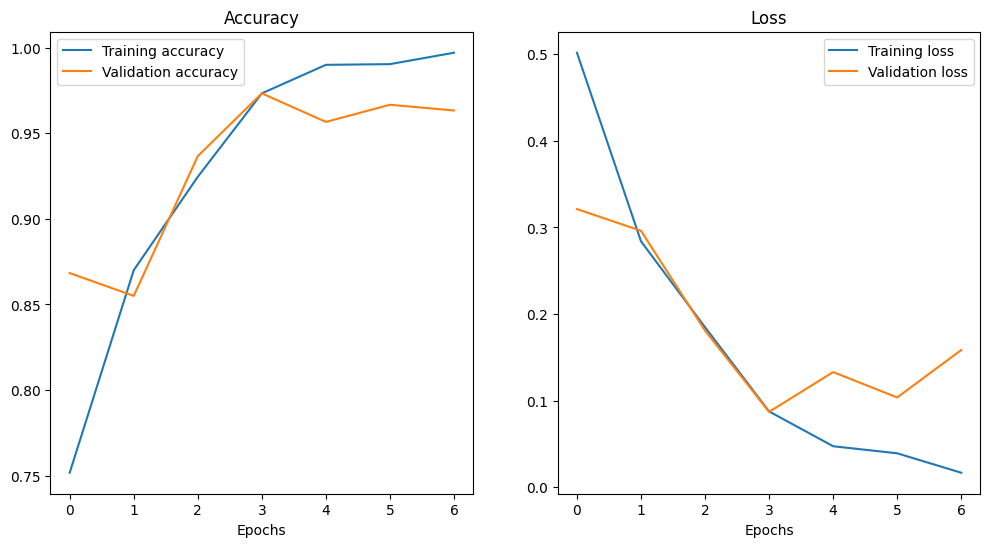

In [23]:

# Plot the training and validation accuracy and loss at each epoch
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(func_history.history["accuracy"], label="Training accuracy")
axes[0].plot(func_history.history["val_accuracy"], label="Validation accuracy")
axes[0].set_xlabel("Epochs")
axes[0].legend()
axes[0].set_title("Accuracy")

axes[1].plot(func_history.history["loss"], label="Training loss")
axes[1].plot(func_history.history["val_loss"], label="Validation loss")
axes[1].set_xlabel("Epochs")
axes[1].legend()
axes[1].set_title("Loss")

plt.show()